In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

im_ref, im_us = dd.get_dataset(1)
#im_us_aug = dd.augment_channel_image(im_us)
X_train, y_train = (im_us,  im_ref)

im_ref_test, im_us_test = dd.get_dataset(3)
#im_us_test_aug = dd.augment_channel_image(im_us_test)
X_test, y_test = (im_us_test, im_ref_test)



In [4]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Training data shape: ', (320, 320, 256, 8))
('Training labels shape: ', (320, 320, 256, 1))
('Test data shape: ', (320, 320, 256, 8))
('Test labels shape: ', (320, 320, 256, 1))


In [8]:
from unetblocks import res_block, gen_conv_relu, gen_conv_bn_relu

input_shape = X_train.shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)

gen_conv_params = lambda num_filters : {'filters': num_filters, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
f16 = gen_conv_params(16)
f32 = gen_conv_params(32)
f64 = gen_conv_params(64)
f128 = gen_conv_params(128)
f256 = gen_conv_params(256)
f512 = gen_conv_params(512)
f1024 = gen_conv_params(1024)

#gen_fn = gen_conv_bn_relu
gen_fn = gen_conv_relu
N = 1 # number of repeats on conv block
# small unet
res_out = res_block(gen_fn(N=2, **f16), gen_fn(N=2, **f16))(inputs, 
                                                      resblocks=[res_block(gen_fn(N=3, **f32), gen_fn(N=3, **f32)),
                                                                 res_block(gen_fn(N=3, **f64), gen_fn(N=3, **f64)),
                                                                         res_block(gen_fn(N=3, **f128))])

# big unet
'''
res_out = res_block(gen_fn(N=2, **f32), gen_fn(N=2, **f32))(inputs, 
                                                      resblocks=[res_block(gen_fn(N=2, **f64), gen_fn(N=2, **f64)),
                                                                 res_block(gen_fn(N=2, **f128), gen_fn(N=2, **f128)),
                                                                 res_block(gen_fn(N=2, **f256), gen_fn(N=2, **f256)),
                                                                         res_block(gen_fn(N=2, **f512))])
'''                                                                         

out = tf.keras.layers.Dense(1)(res_out)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
## example from https://keras.io/callbacks/
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/pkllee/tmp/')

#adam_optimizer = tf.keras.optimizers.Adam(lr=0.1, beta_1 = 0.9, beta_2=0.999, decay=0.1)
adam_optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=0.01)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mse'])

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 256, 8)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 320, 256, 16) 1168        input_2[0][0]                    
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 320, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 320, 256, 16) 2320        activation_20[0][0]              
__________________________________________________________________________________________________
activation

In [11]:
model.fit(x=X_train, y=y_train, callbacks=[history, tb_callback], epochs=100, batch_size=10)

Epoch 1/2
320/320 [==============================] - 149s 464ms/step - loss: 1.8357e-04 - mean_squared_error: 1.8357e-04
Epoch 2/2
320/320 [==============================] - 146s 457ms/step - loss: 1.4058e-04 - mean_squared_error: 1.4058e-04


<IPython.core.display.Javascript object>


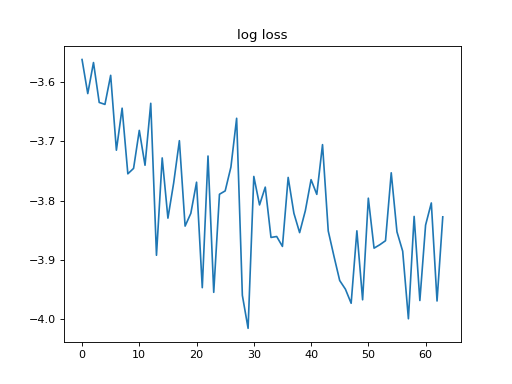

In [12]:
plt.plot(np.log10(history.losses))
plt.title('log loss')
plt.show()

In [13]:
def sos(im, axis):
    return np.sqrt(np.sum(np.power(im, 2), axis=axis))

pred_test = model.predict(X_test)
to_show_ref_test = y_test
to_show_us_test = X_test

pred_train = model.predict(X_train)
to_show_ref_train  = y_train
to_show_us_train = X_train

#mean_squared_error = tf.keras.losses.mean_squared_error(pred_test, to_show_ref_test)
#print(mean_squared_error)

In [14]:
slice_to_show = 60

def show_images(slice_to_show, pred, ref, us):
    im1 = pred[slice_to_show, :, :, 0]    
    im2 = ref[slice_to_show, :, :, 0]
    im3 = sos(us[slice_to_show, :, :, :], axis=2)

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.hstack((im1, im2, im3)), cmap='gray')
    plt.title('pred | ref | us')
    plt.axis('off')
    plt.show()

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(abs(im2 - im1)* 10, cmap='gray', vmin=0, vmax=1)
    plt.title('diff x10')
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>


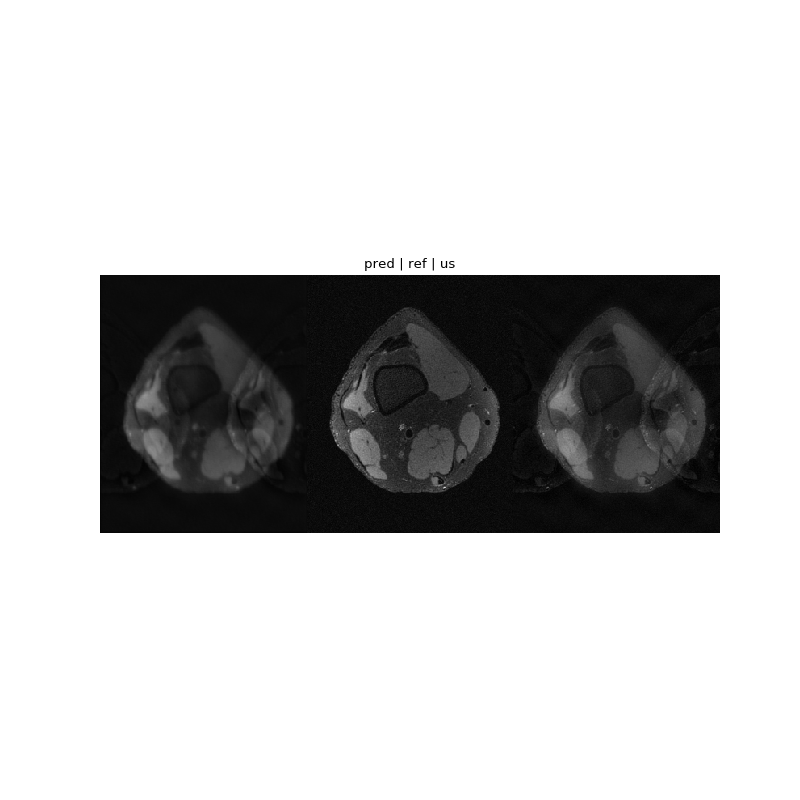

<IPython.core.display.Javascript object>


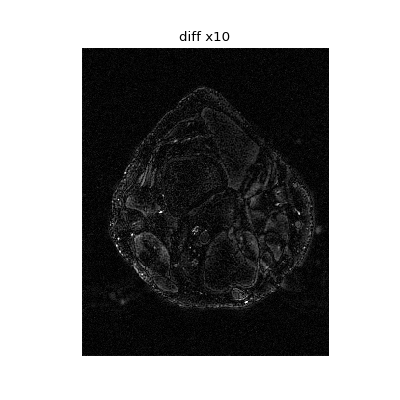

In [15]:
show_images(slice_to_show, pred_test, to_show_ref_test, to_show_us_test)

<IPython.core.display.Javascript object>


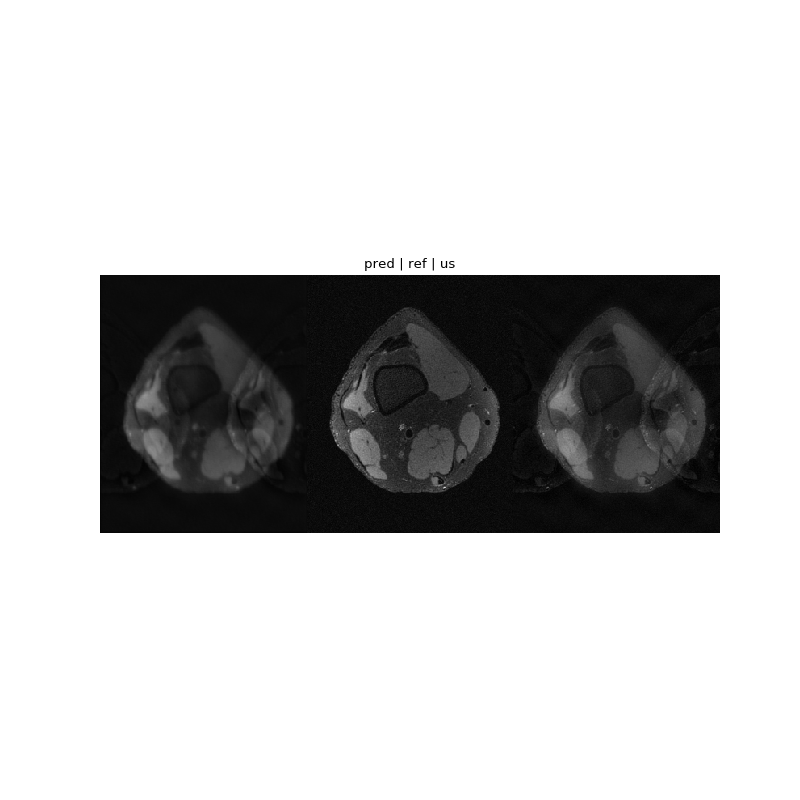

<IPython.core.display.Javascript object>


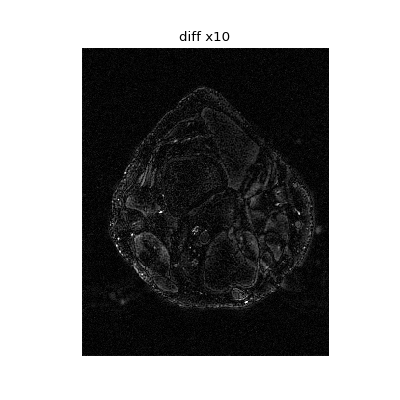

In [16]:
show_images(slice_to_show, pred_train, to_show_ref_train, to_show_us_train)